In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

import os
import json
import folium as fo

# Part 3

## 3.1
First, we need to show the difference in unemployment rates between swiss and foreigners. We decided to take the available data of the current year (2017).

Instead of showing two different maps, we compute the difference of the unemployment rate between swiss and foreigners per canton, and then we draw only one map showing this difference.

The dataset contains unemployment rate for swiss and foreign workers per month and canton during 2017 for far. 

In [2]:
# load the csv file
df = pd.read_csv('./unemployment_swiss_foreigner.csv', encoding='utf-8')

We build a dictionnary to pass from canton full name to the 2-letters acronym as the topojson file uses that

In [3]:
# dictionary from canton full name to canton short name
canton_list = [['Zurich', 'Berne', 'Lucerne', 'Uri', 'Schwyz', 'Obwald', 'Nidwald',
                'Glaris', 'Zoug', 'Fribourg', 'Soleure', 'Bâle-Ville', 'Bâle-Campagne',
                'Schaffhouse', 'Appenzell Rhodes-Extérieures', 'Appenzell Rhodes-Intérieures',
                'St-Gall', 'Grisons', 'Argovie', 'Thurgovie', 'Tessin', 'Vaud', 'Valais',
                'Neuchâtel', 'Genève', 'Jura'],
               ['ZH','BE','LU', 'UR', 'SZ', 'OW', 'NW', 'GL', 'ZG', 'FR','SO', 'BS', 'BL',
                'SH', 'AR', 'AI', 'SG', 'GR', 'AG', 'TG', 'TI', 'VD', 'VS', 'NE', 'GE', 'JU']]

canton_dict = {canton_list[0][x] : canton_list[1][x] for x in range(len(canton_list[1]))}

In [4]:
# rename columns
unemployment = df[['Unnamed: 0', 'Nationalité', 'Total']]
unemployment.columns = ['Canton', 'Nationalité', 'Total']

# drop unnecessary index
unemployment = unemployment.drop(unemployment.index[0])

# add column of short name
unemployment['short_name'] = unemployment.Canton.map(lambda x: canton_dict[x] if x in canton_dict else x)

# change total column to numercic values
unemployment = unemployment.apply(pd.to_numeric, errors='ignore')
unemployment.head()

,Canton,Nationalité,Total,short_name
1,Zurich,Etrangers,5.3,ZH
2,Zurich,Suisses,2.4,ZH
3,Berne,Etrangers,5.7,BE
4,Berne,Suisses,1.8,BE
5,Lucerne,Etrangers,4.0,LU


As the rate is always bigger for foreigners, all differences have the same sign, therfore we can put all differences positive.

In [5]:
# dataframe containing the rate difference between foreigners and swiss' unemployment rate
un_diff = pd.DataFrame()
un_diff['short_name'] = unemployment.short_name
un_diff['difference'] = unemployment.groupby(['Canton']).diff(-1)
un_diff = un_diff.dropna()
un_diff.head()

,short_name,difference
1,ZH,2.9
3,BE,3.9
5,LU,2.8
7,UR,3.4
9,SZ,2.4


Now we can draw the choropleth map using the 2 column dataframe containing the difference rate. We would have used a 2-color scale if the differences were positive and negative (for example white in the middle, blue for one side and red for the other) but as the scale is only positive, we only used 1 color.  

In [6]:
geo_path = r'topojson/ch-cantons.topojson.json'
geo_json_data = json.load(open(geo_path))

swiss_coord = [46.8182, 8.22]

In [7]:
# choropleth of difference rate
ch_map = fo.Map(location=swiss_coord,
                tiles='cartodbpositron',
                zoom_start=8)

ch_map.choropleth(geo_data=geo_json_data, data=un_diff,
                  columns=['short_name', 'difference'],
                  key_on='feature.id',
                  fill_color='YlGn', fill_opacity=0.9, line_opacity=0.8,
                  legend_name = "rate difference between unemployed foreigners and swiss people in (%)",
                  topojson = 'objects.cantons')

#Save the map as an HTML file
fn='swiss_diff.html'
ch_map.save(fn)

[Link to the map](swiss_diff.html)

We can see that the differences are more visible in Jura and Valais, follow by Berne, Neuchâtel and Argovie.
Why do you think that is ?

### Just for the exercise, we also show the map of swiss and foreigners unemployement rates, like it was naively proposed.

In [8]:
# choropleth of swiss workers unemployment rate
un_swiss = unemployment.loc[unemployment.Nationalité == 'Suisses']

ch_map = fo.Map(location=swiss_coord,
                tiles='cartodbpositron',
                zoom_start=8)

ch_map.choropleth(geo_data=geo_json_data, data=un_swiss,
                  columns=['short_name', 'Total'],
                  key_on='feature.id',
                  fill_color='OrRd', fill_opacity=0.9, line_opacity=0.8,
                  legend_name = "unemployment rate for swiss workers in (%)",
                  topojson = 'objects.cantons')

#Save the map as an HTML file
fn='swiss_unemployment.html'
ch_map.save(fn)

[Link to the map](swiss_unemployment.html)

In [9]:
# choropleth of foreigner workers unemployment rate
un_foreigners = unemployment.loc[unemployment.Nationalité == 'Etrangers']

ch_map = fo.Map(location=swiss_coord,
                tiles='cartodbpositron',
                zoom_start=8)

ch_map.choropleth(geo_data=geo_json_data, data=un_foreigners,
                  columns=['short_name', 'Total'],
                  key_on='feature.id',
                  fill_color='BuPu', fill_opacity=0.9, line_opacity=0.8,
                  legend_name = "unemployment rate for foreigner workers in (%)",
                  topojson = 'objects.cantons')

#Save the map as an HTML file
fn='forei_unemployment.html'
ch_map.save(fn)

[Link to the map](forei_unemployment.html)

## 3.2
Now we want to display the same analysis and add the differences between age groups. Saldy, the amstat website doesn't allow to simply get the data with the nationaly factor and the age factor, we can only get one at the time. One way to work around this limitation is to divide in two groups : "chômeurs jeunes" and "chômeurs adultes" (young unemployed and adult unemployed). Young is defined to be between 15-24 and adult is 24+.

The amstat website allow us to get total number of unemployed and the total number of young unemployed, along with the corresponding rates, with the nationality factor and per canton. From this values we can get the unemployment rate for adults.

In [10]:
import numpy as np
# load the csv file
df = pd.read_csv('./unemployment_swiss_foreigner_young_total.csv', encoding='utf-16', index_col=[0,1,2]).T
df = df.replace('...', np.nan)
df = df.apply(pd.to_numeric, errors='ignore')
df.head()


Canton                Zurich                                               \
Nationalité        Etrangers                                                
Valeurs      Taux de chômage Taux de chômage des jeunes Chômeurs inscrits   
Janvier 2017             6.6                        6.9             15060   
Février 2017             6.5                        6.8             14787   
Mars 2017                6.3                        6.6             14382   
Avril 2017               6.0                        5.8             13572   
Mai 2017                 5.7                        5.4             13097   

Canton                                                                   \
Nationalité                          Suisses                              
Valeurs      Chômeurs jeunes Taux de chômage Taux de chômage des jeunes   
Janvier 2017            1194             2.9                        3.5   
Février 2017            1185             2.8                        3.3   
Mars 2017               1147             2.8                        3.1   
Avril 2017              1009             2.7                        2.8   
Mai 2017                 936             2.6                        2.6   

Canton                                                   Berne  \
Nationalité                                          Etrangers   
Valeurs      Chômeurs inscrits Chômeurs jeunes Taux de chômage   
Janvier 2017             17327            2606             7.5   
Février 2017             16832            2438             7.4   
Mars 2017                16459            2282             7.1   
Avril 2017               15970            2094             6.8   
Mai 2017                 15527            1962             6.2   

Canton                                        ...                  Genève  \
Nationalité                                   ...                 Suisses   
Valeurs      Taux de chômage des jeunes       ...       Chômeurs inscrits   
Janvier 2017                        8.1       ...                    6541   
Février 2017                        8.2       ...                    6342   
Mars 2017                           7.8       ...                    6274   
Avril 2017                          7.2       ...                    6143   
Mai 2017                            6.6       ...                    6093   

Canton                                  Jura                             \
Nationalité                        Etrangers                              
Valeurs      Chômeurs jeunes Taux de chômage Taux de chômage des jeunes   
Janvier 2017             635            11.9                        NaN   
Février 2017             587            11.5                        NaN   
Mars 2017                549            10.7                        NaN   
Avril 2017               500            10.0                        NaN   
Mai 2017                 485             9.5                        NaN   

Canton                                                          \
Nationalité                                            Suisses   
Valeurs      Chômeurs inscrits Chômeurs jeunes Taux de chômage   
Janvier 2017               666              68             4.1   
Février 2017               645              66             4.1   
Mars 2017                  598              67             3.8   
Avril 2017                 561              55             3.7   
Mai 2017                   534              43             3.5   

Canton                                                                     
Nationalité                                                                
Valeurs      Taux de chômage des jeunes Chômeurs inscrits Chômeurs jeunes  
Janvier 2017                        5.6              1264             260  
Février 2017                        5.6              1270             260  
Mars 2017                           4.8              1184             223  
Avril 2017                          4.5           

We can get the #young and #workers by dividing the number of unemployed by the unemployment rate.

The adult rate can be calculated the following way: #adult_unemployed/#adult

Where #adult_unemployed = #total_unemployed - #young_unemployed

and #adult = #workers -#young

In [11]:
df_final = pd.DataFrame()

# for each ['Canton', 'Nationality'] we compute the unemployment rate of adults
for title,table in df.groupby(level=[0,1], axis=1):
    
    # number of unemployed for each category
    num_un_young = table[title[0]][title[1]]['Chômeurs jeunes']
    num_un_total = table[title[0]][title[1]]['Chômeurs inscrits']
    num_un_adult = num_un_total - num_un_young
    
    # rate for young and total
    per_un_young = table[title[0]][title[1]]['Taux de chômage des jeunes']
    per_un_total = table[title[0]][title[1]]['Taux de chômage']
    
    # total number for each category
    num_young = num_un_young / (per_un_young * 1.0)
    num_total = num_un_total / (per_un_total * 1.0)
    num_adult = num_total - num_young
    
    # rate for adults
    per_un_adult = num_adult / num_total
    
    # add indexes for the multi-level indexing
    per_un_young = pd.concat([pd.Series([title[0],title[1],'per_un_young']), per_un_young])
    per_un_adult = pd.concat([pd.Series([title[0],title[1],'per_un_adult']), per_un_adult])
    per_un_total = pd.concat([pd.Series([title[0],title[1],'per_un_total']), per_un_total])

    # dataframe with the rates for young, adult and total
    temp_df = pd.DataFrame(data = [per_un_young, per_un_adult, per_un_total])
    
    # append to final dataframe
    df_final = pd.concat((df_final, temp_df), axis=0)
                                 
df_final = df_final.set_index([0,1,2]).T

In [12]:
df_final.head()

0            Appenzell Rhodes-Extérieures                            \
1                               Etrangers                             
2                            per_un_young per_un_adult per_un_total   
Janvier 2017                          NaN          NaN          4.4   
Février 2017                          NaN          NaN          4.2   
Mars 2017                             NaN          NaN          3.8   
Avril 2017                            NaN          NaN          3.9   
Mai 2017                              NaN          NaN          3.7   

0                                                    \
1                 Suisses                             
2            per_un_young per_un_adult per_un_total   
Janvier 2017          1.6     0.839215          1.5   
Février 2017          1.6     0.839142          1.5   
Mars 2017             1.4     0.847025          1.4   
Avril 2017            1.2     0.852564          1.3   
Mai 2017              1.2     0.852999          1.3   

0            Appenzell Rhodes-Intérieures                            \
1                               Etrangers                             
2                            per_un_young per_un_adult per_un_total   
Janvier 2017                          NaN          NaN          6.1   
Février 2017                          NaN          NaN          5.1   
Mars 2017                             NaN          NaN          4.3   
Avril 2017                            NaN          NaN          2.8   
Mai 2017                              NaN          NaN          2.5   

0                             ...              Zoug                            \
1                 Suisses     ...         Etrangers      Suisses                
2            per_un_young     ...      per_un_total per_un_young per_un_adult   
Janvier 2017          0.7     ...               4.5          1.9     0.874058   
Février 2017          0.5     ...               4.5          1.9     0.876050   
Mars 2017             0.4     ...               4.4          1.7     0.872995   
Avril 2017            0.5     ...               4.3          1.7     0.879389   
Mai 2017              0.2     ...               4.2          1.5     0.879594   

0                               Zurich                                         \
1                            Etrangers                                Suisses   
2            per_un_total per_un_young per_un_adult per_un_total per_un_young   
Janvier 2017          1.9          6.9     0.924164          6.6          3.5   
Février 2017          1.9          6.8     0.923398          6.5          3.3   
Mars 2017             1.9          6.6     0.923873          6.3          3.1   
Avril 2017            1.8          5.8     0.923092          6.0          2.8   
Mai 2017              1.8          5.4     0.924563          5.7          2.6   

0                                       
1                                       
2            per_un_adult per_un_total  
Janvier 2017     0.875382          2.9  
Février 2017     0.877103          2.8  
Mars 2017        0.874770          2.8  
Avril 2017       0.873562          2.7  
Mai 2017         0.873639          2.6  

[5 rows x 156 columns]

We can see that some columns are missing the values. It's because some small canton don't have the unemployment rate of young people.

Next step is to plot everything with bars. We did it in two different ways:

1) New plot for each month

2) New plot for each canton

In [13]:
# change the size of plots for better vizulization
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Leonovo\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['title', 'table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


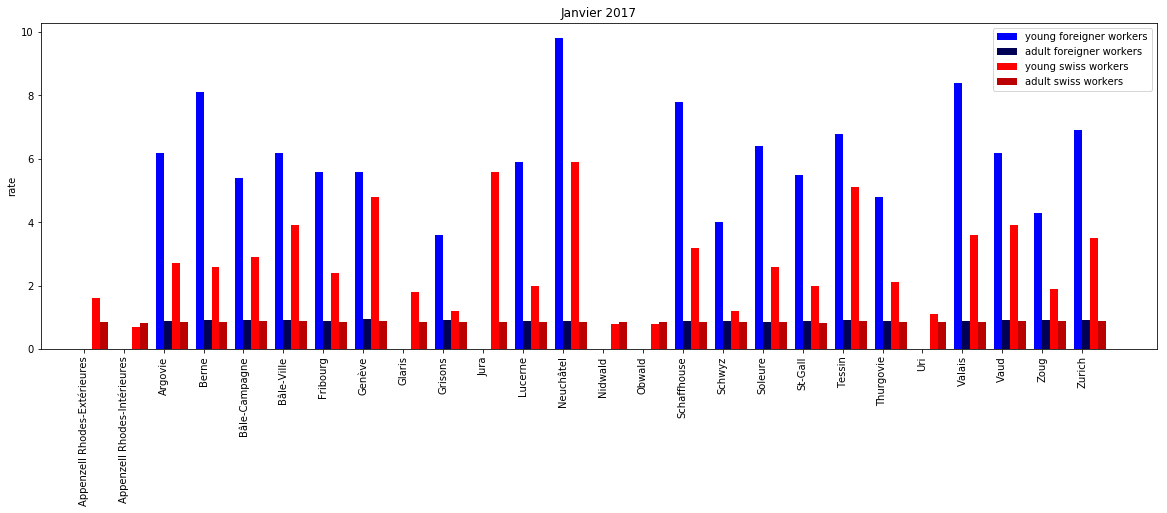

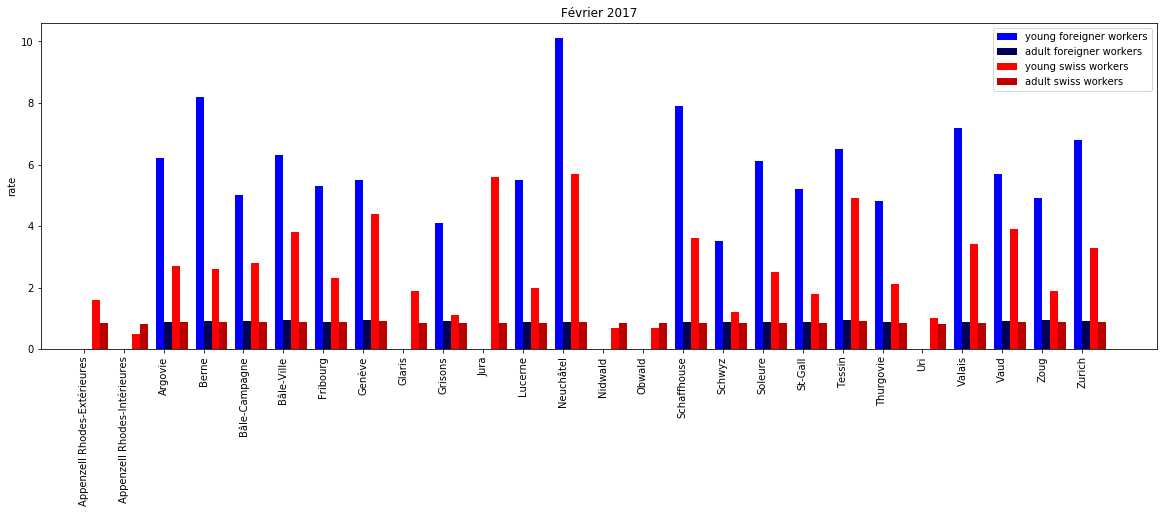

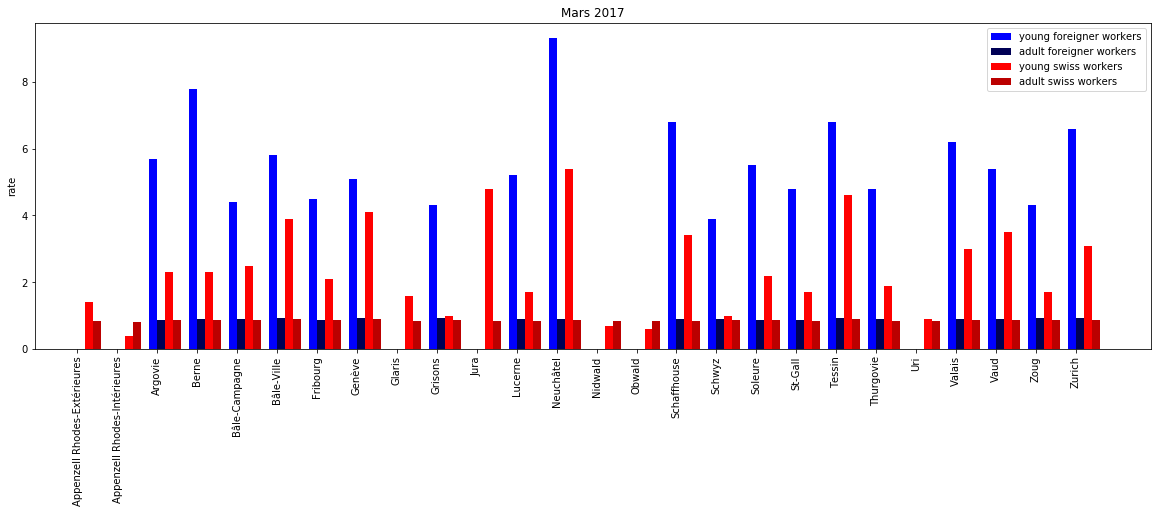

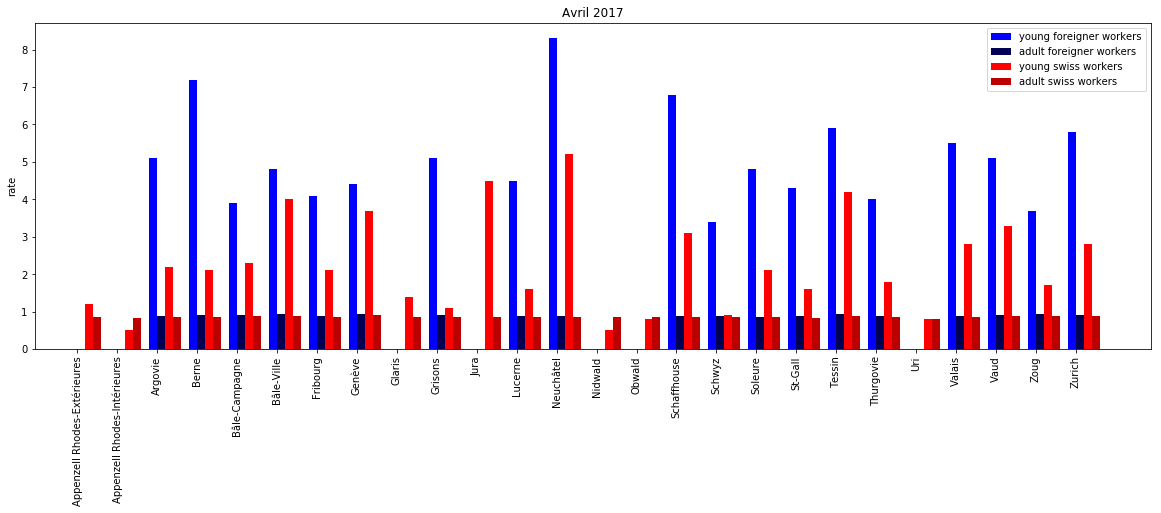

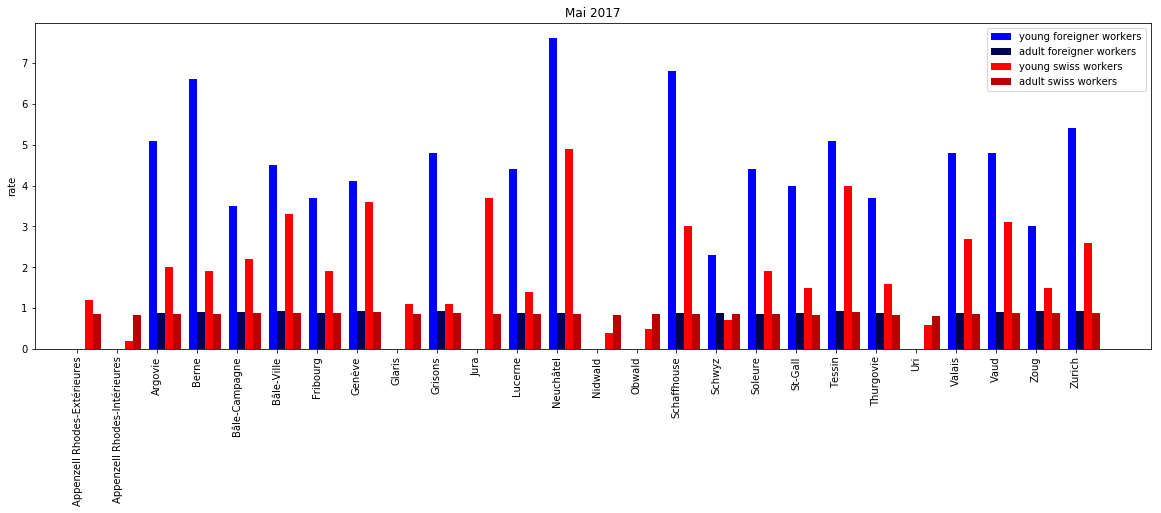

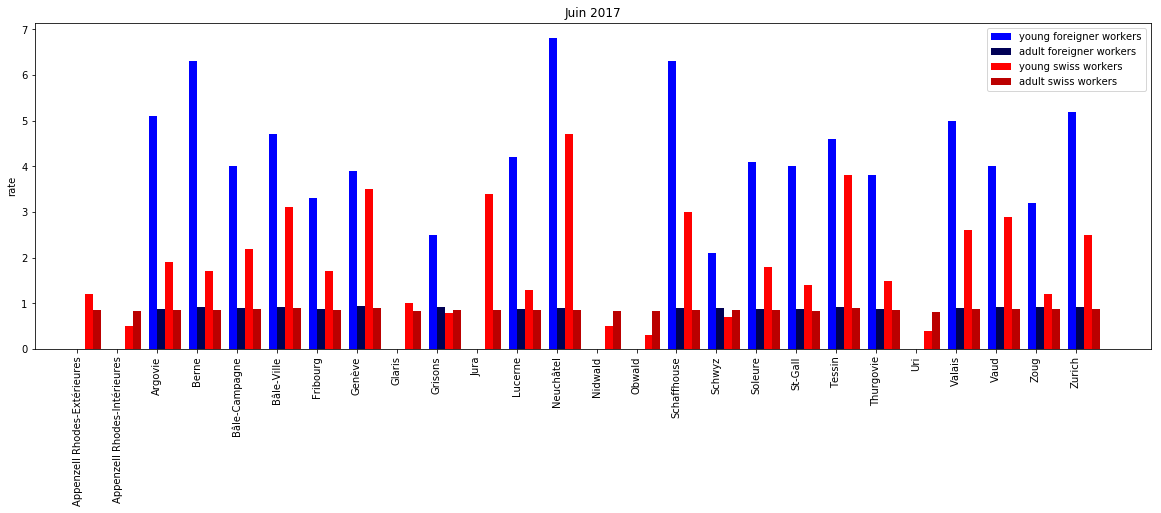

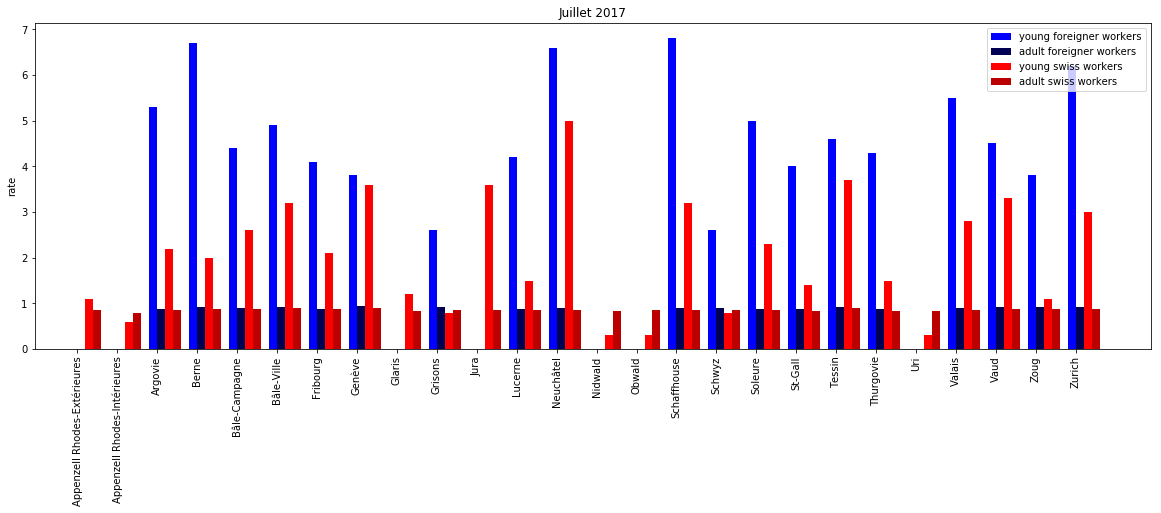

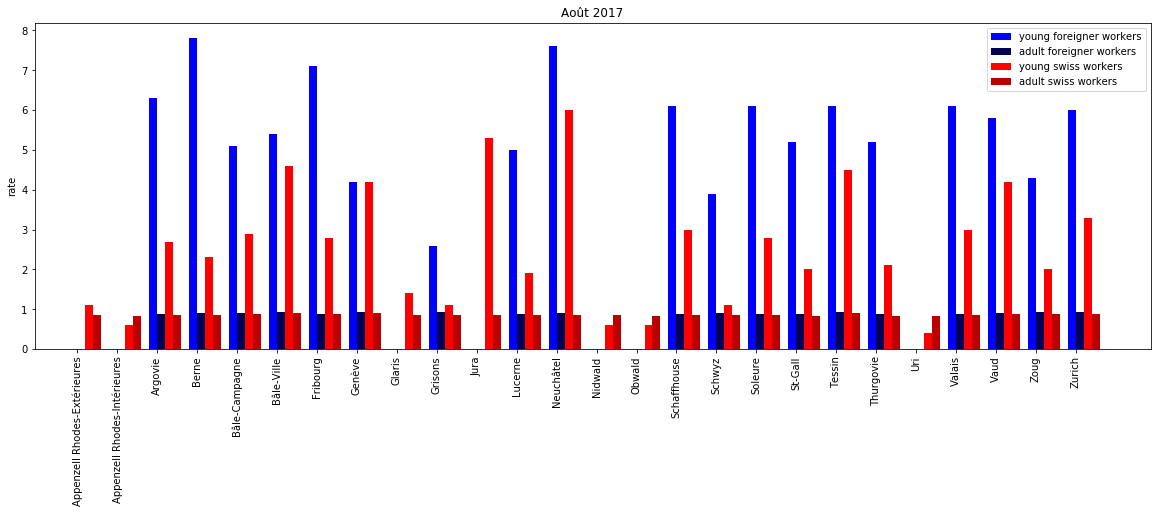

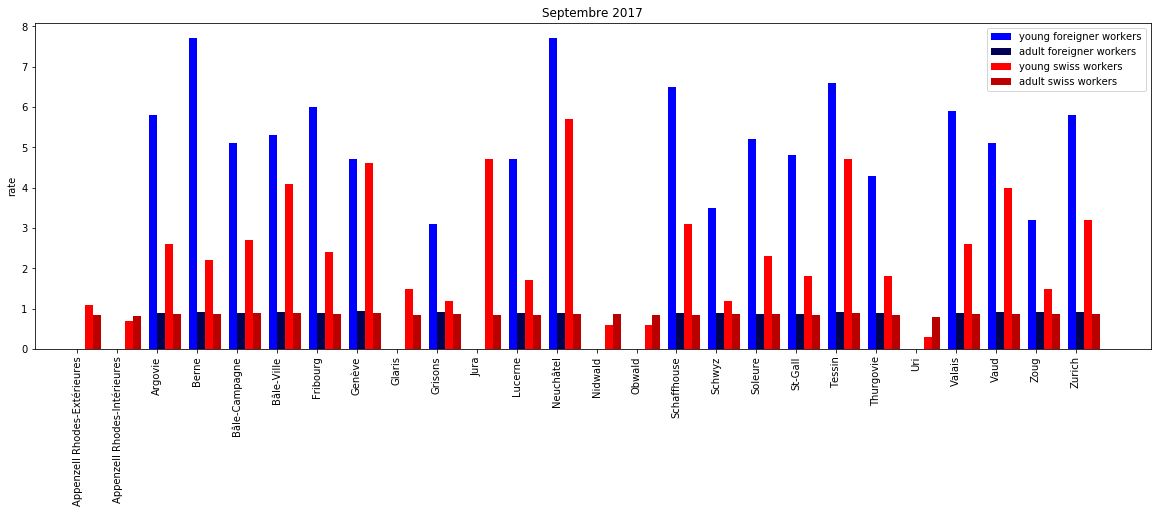

In [14]:
for month,data in df_final.iterrows():
    N = 26
    un_young_foreigner = []
    un_adult_foreigner = []
    un_young_swiss = []
    un_adult_swiss = []
    
    labels = []
    
    ind = np.arange(0,10*N,10)  # the x locations for the groups
    width = 2       # the width of the bars
    
    fig, ax = plt.subplots()
    
    for title,table in data.groupby(level=[0]):
        un_young_foreigner.append(table[0])
        un_adult_foreigner.append(table[1])
        un_young_swiss.append(table[3])
        un_adult_swiss.append(table[4])
        labels.append(title)
    
    rects1 = ax.bar(ind, un_young_foreigner, width, color='#0000ff')
    rects2 = ax.bar(ind+width, un_adult_foreigner, width, color='#000055')
    rects3 = ax.bar(ind+2*width, un_young_swiss, width, color='#ff0000')
    rects4 = ax.bar(ind+3*width, un_adult_swiss, width, color='#bb0000')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('rate')
    ax.set_title(month)

    ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),
              ('young foreigner workers', 'adult foreigner workers', 'young swiss workers', 'adult swiss workers'))
    plt.xticks(ind + width / 2, labels, rotation='vertical')
    plt.show()

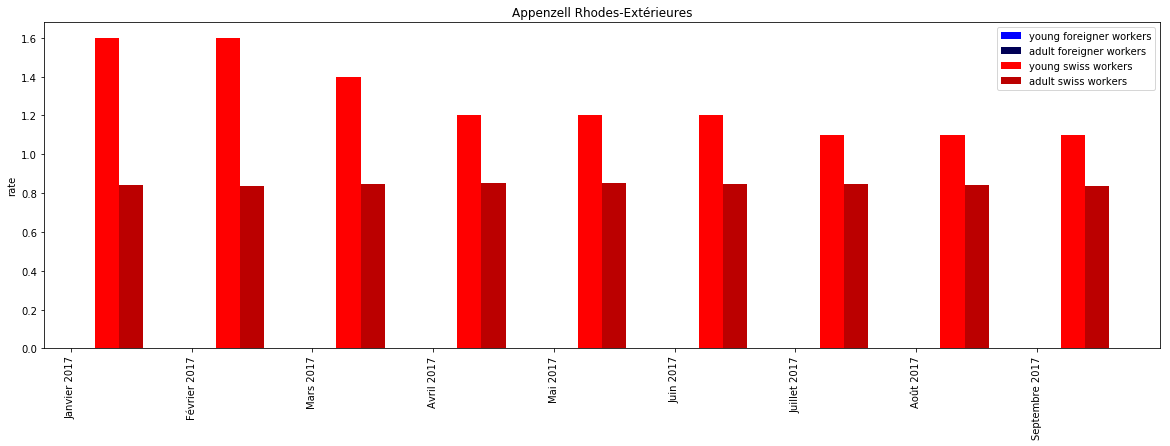

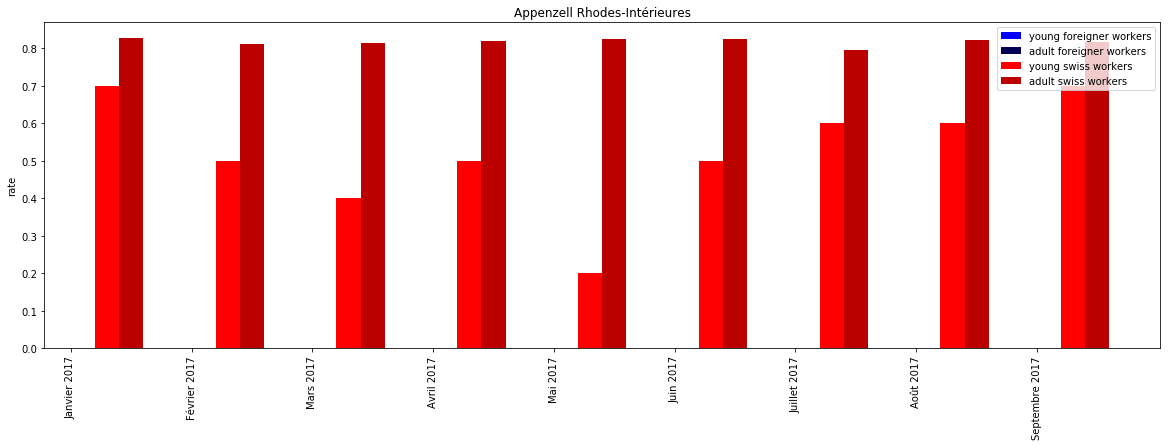

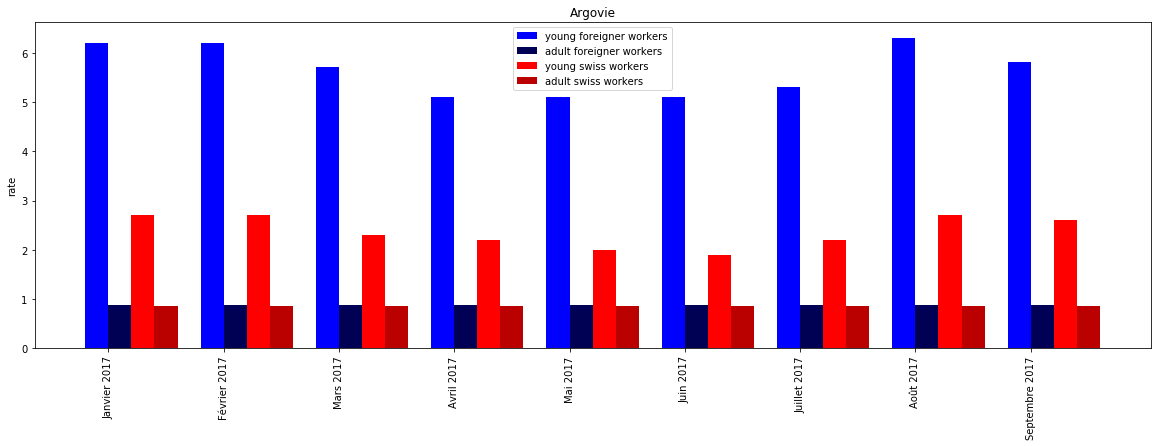

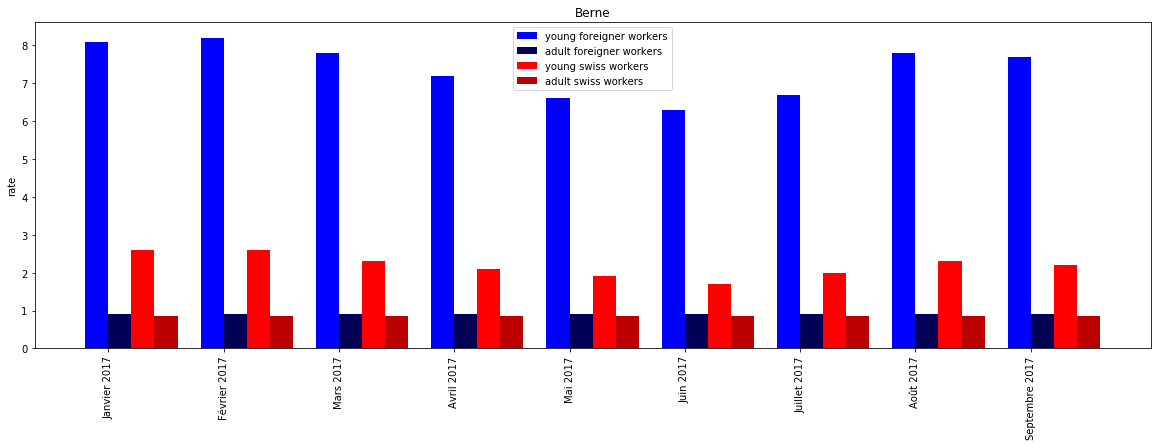

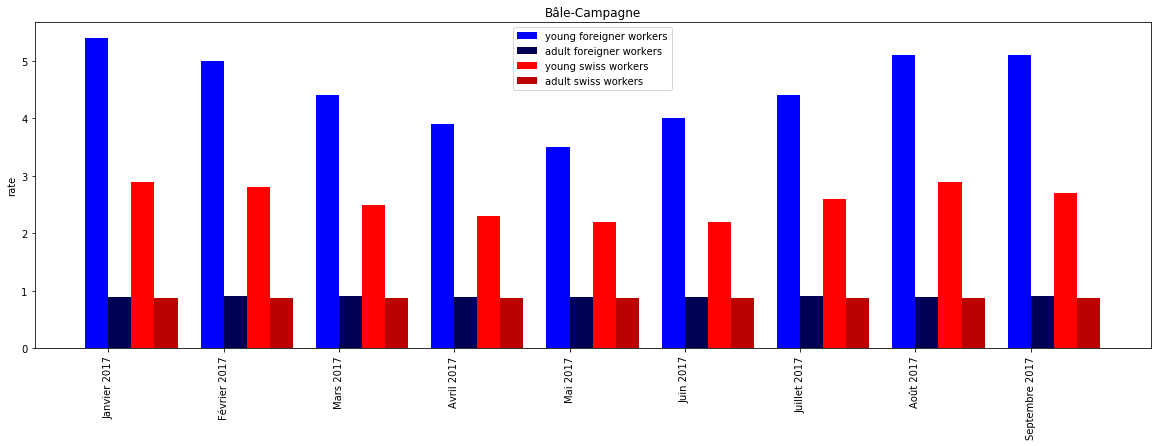

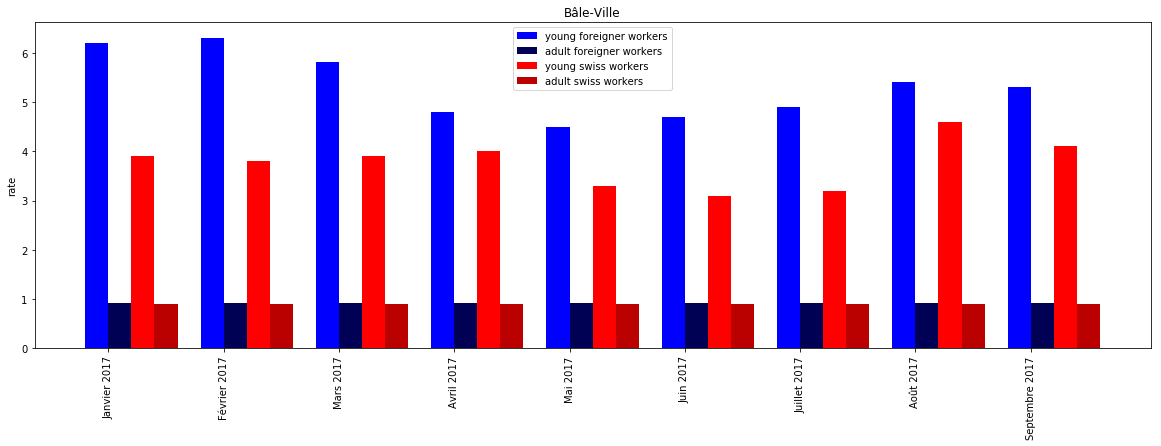

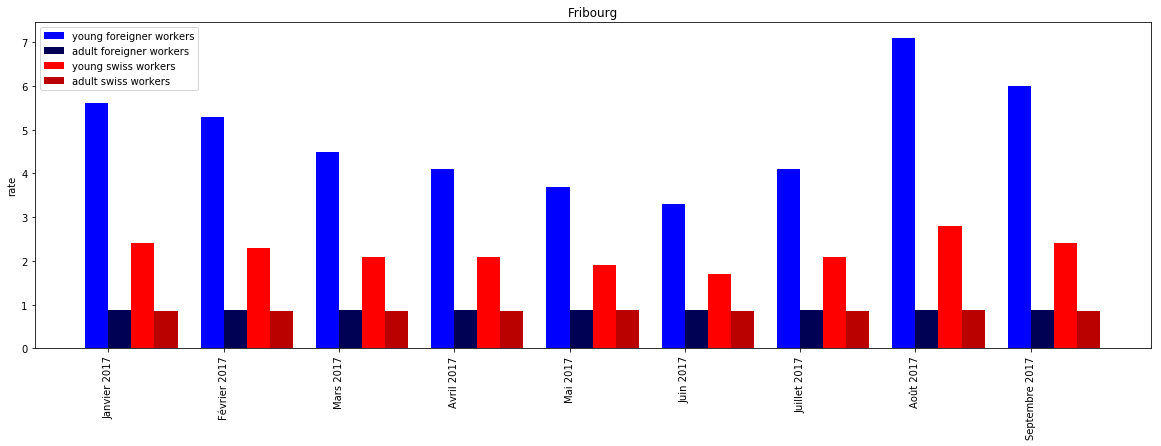

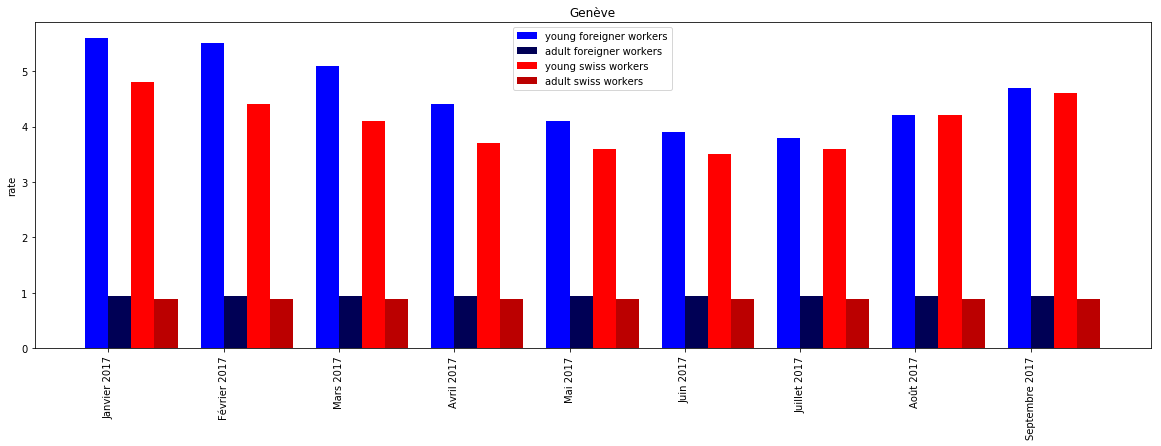

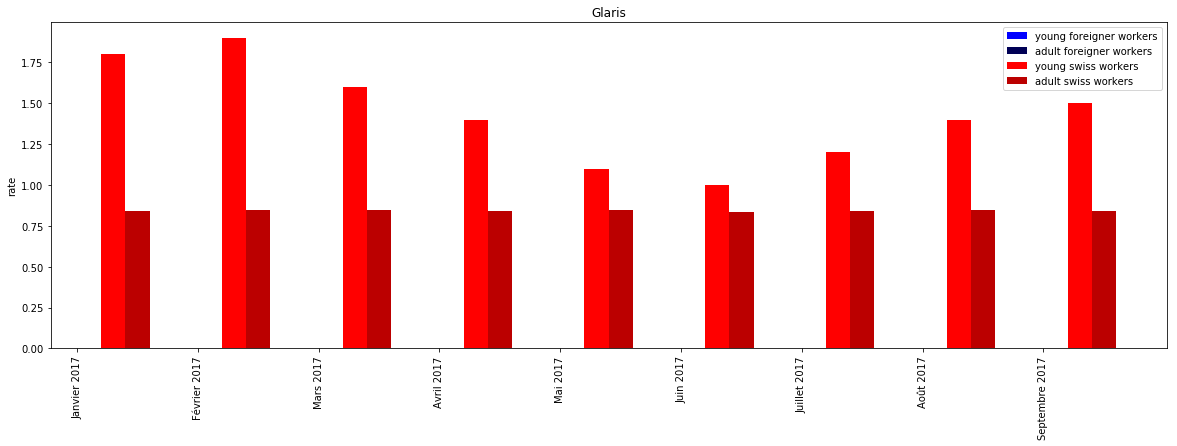

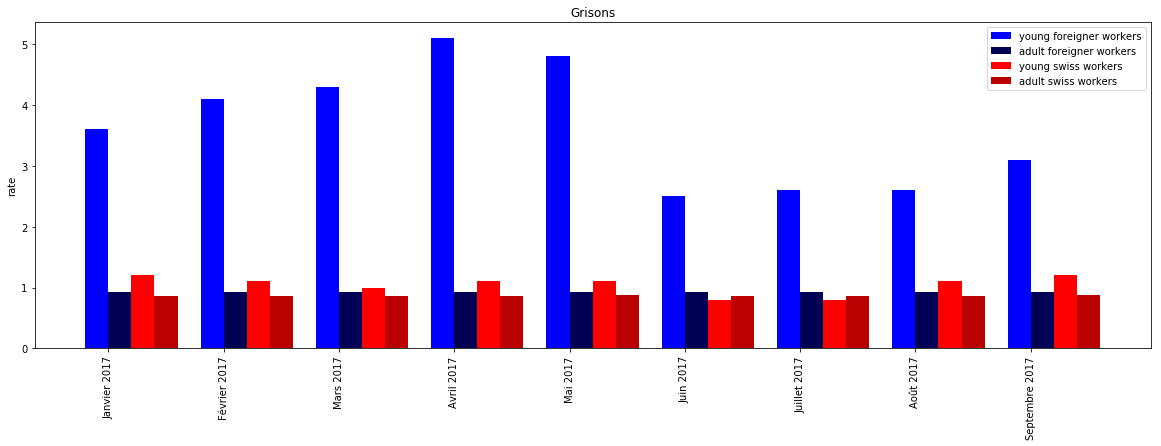

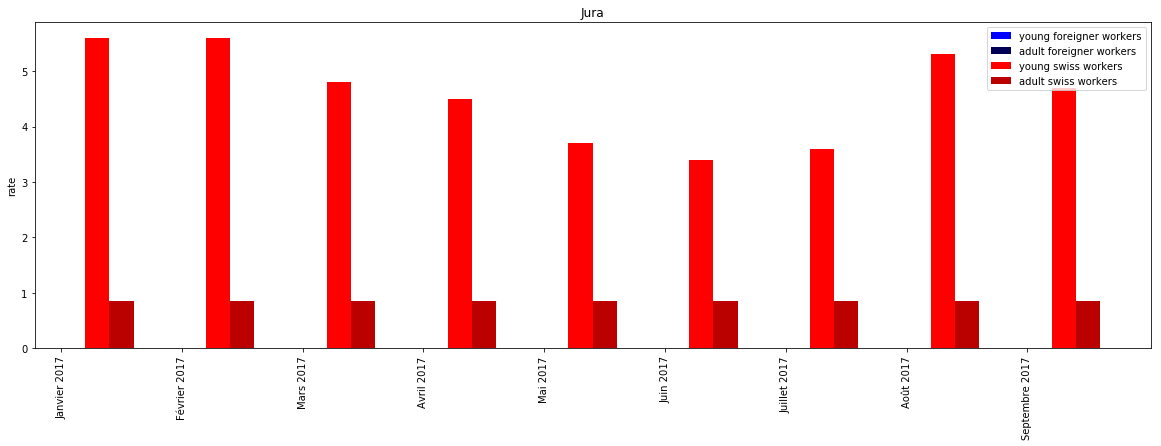

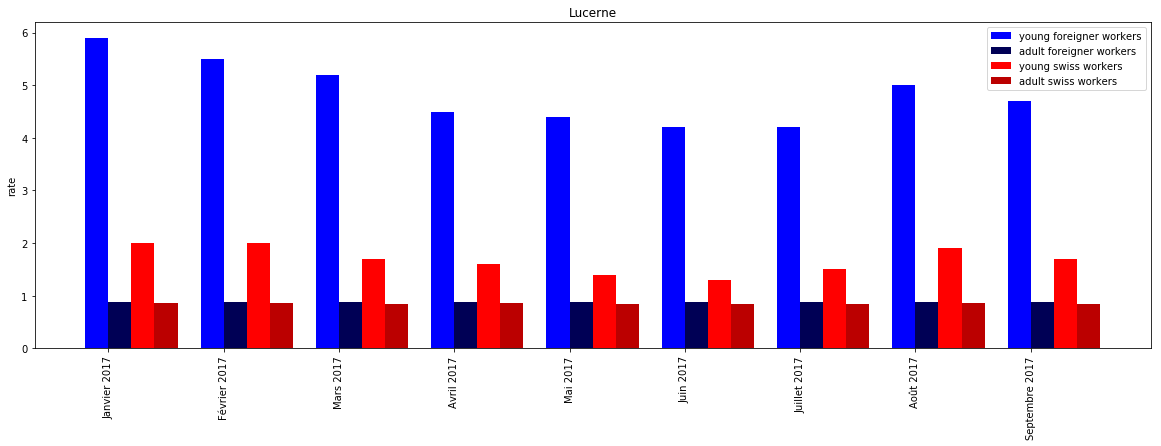

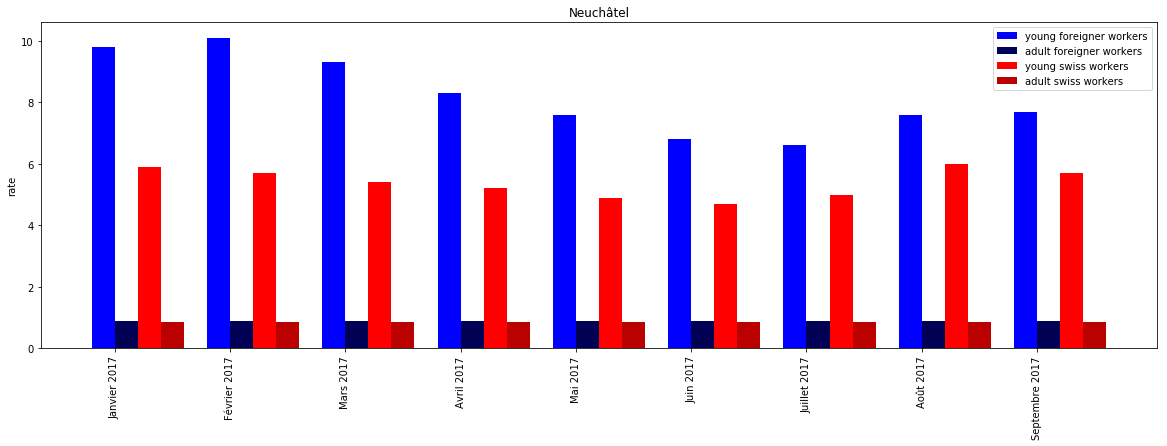

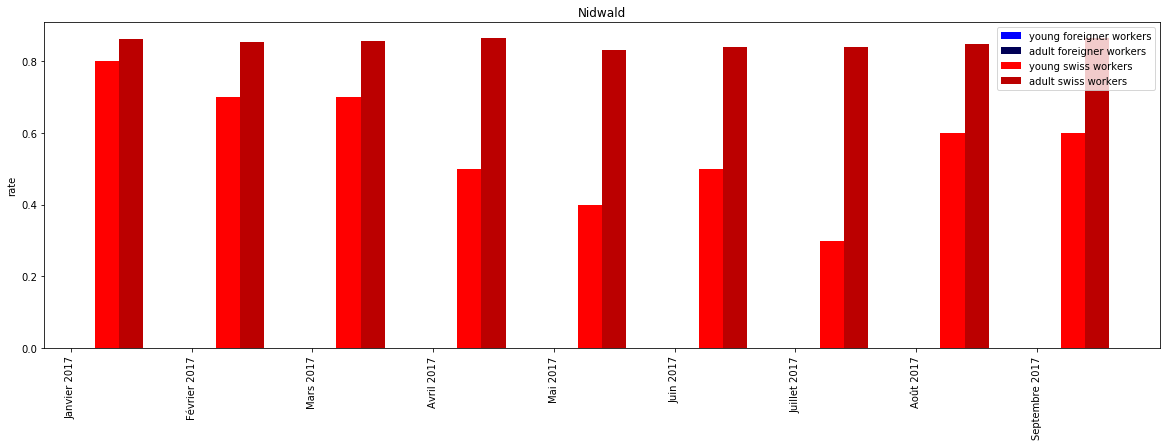

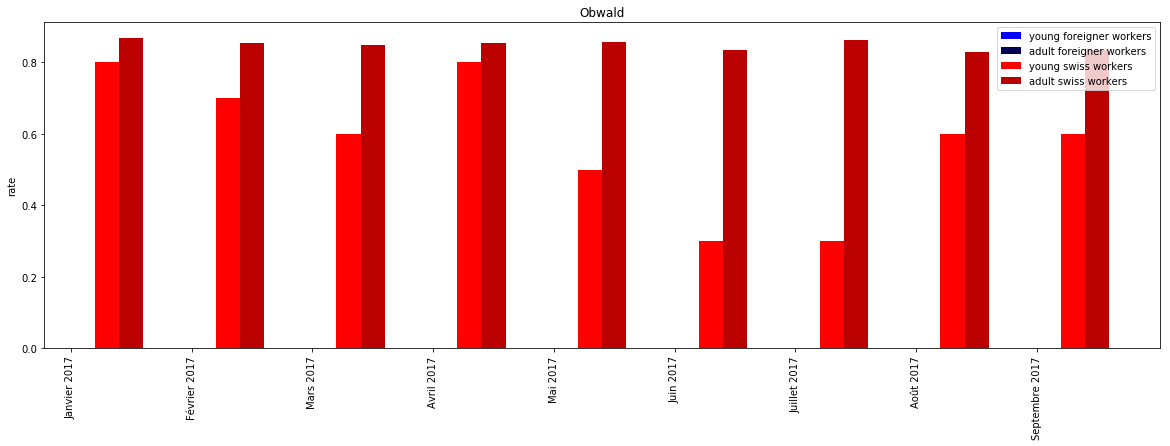

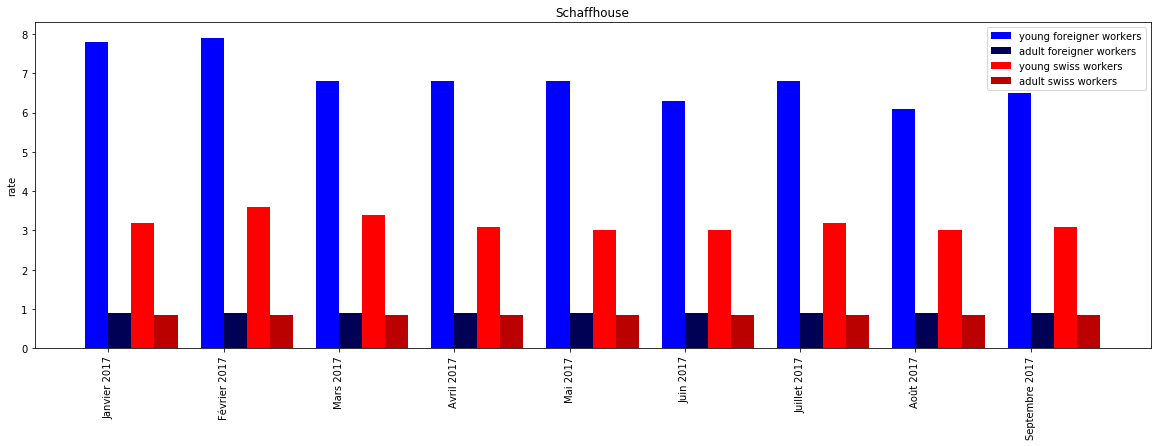

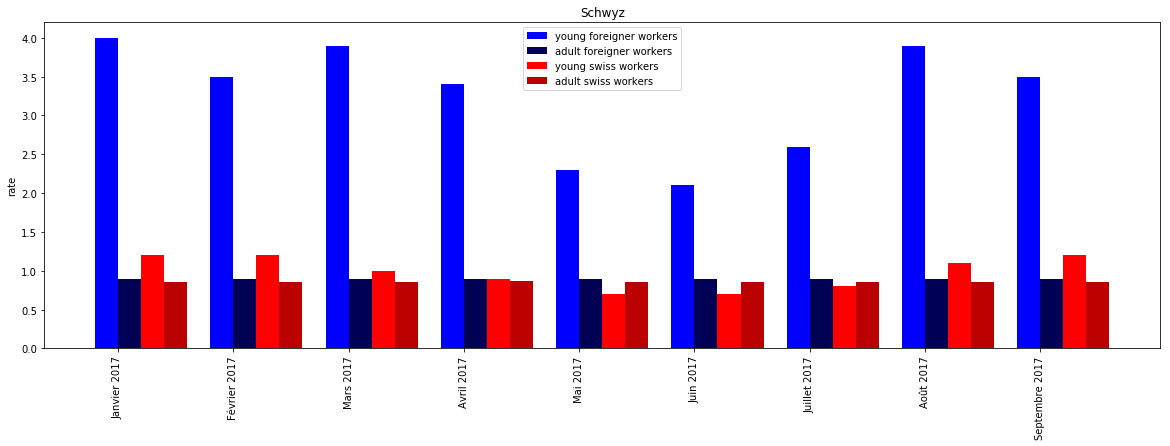

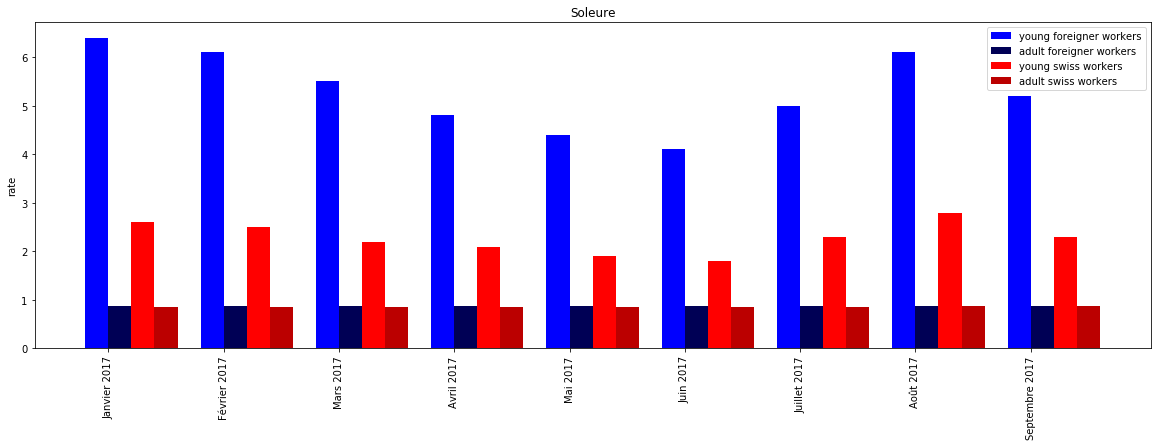

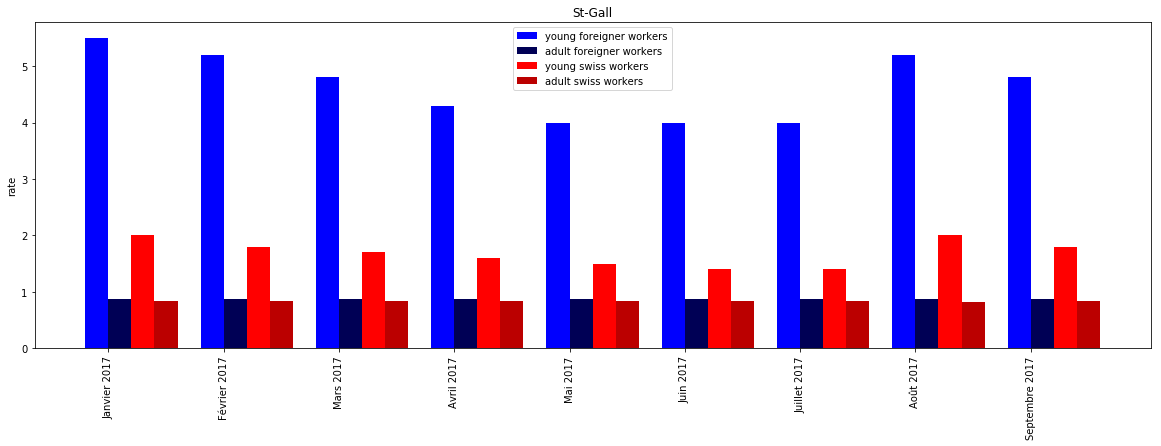

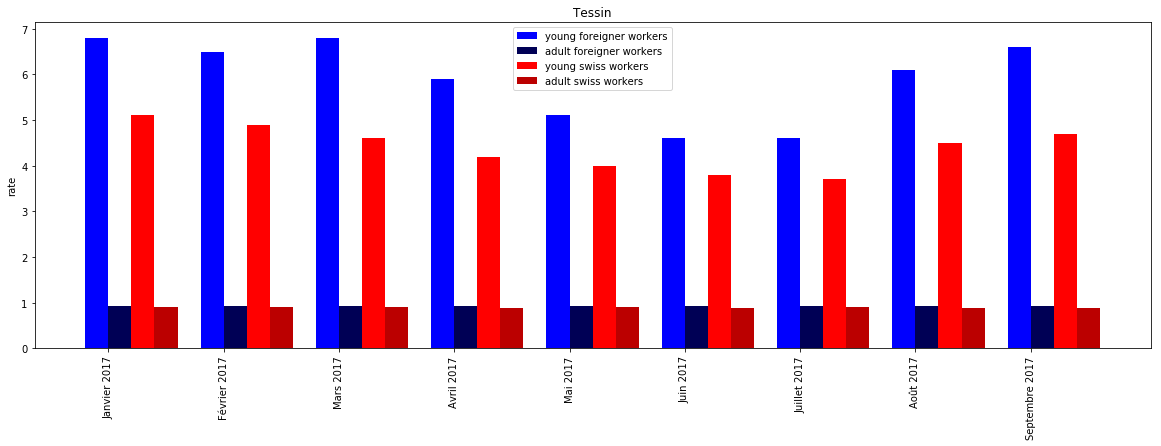

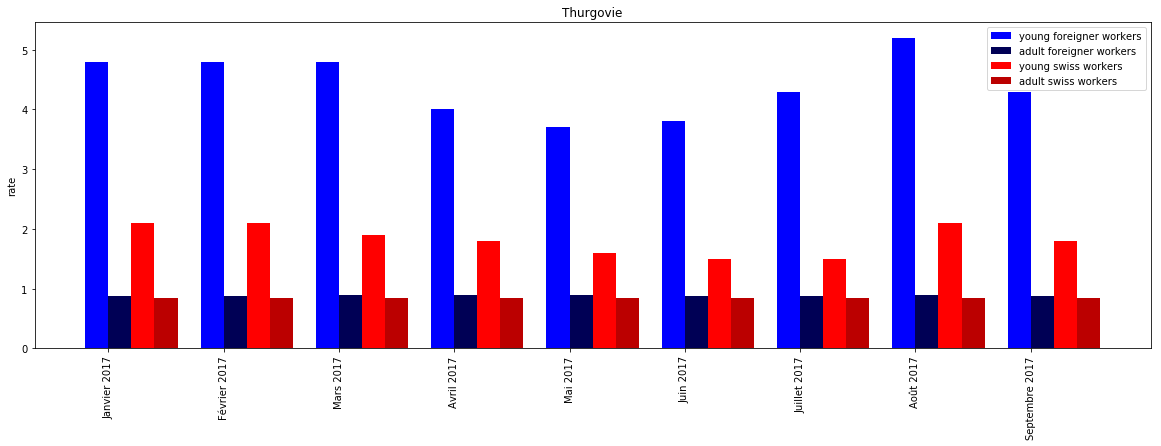

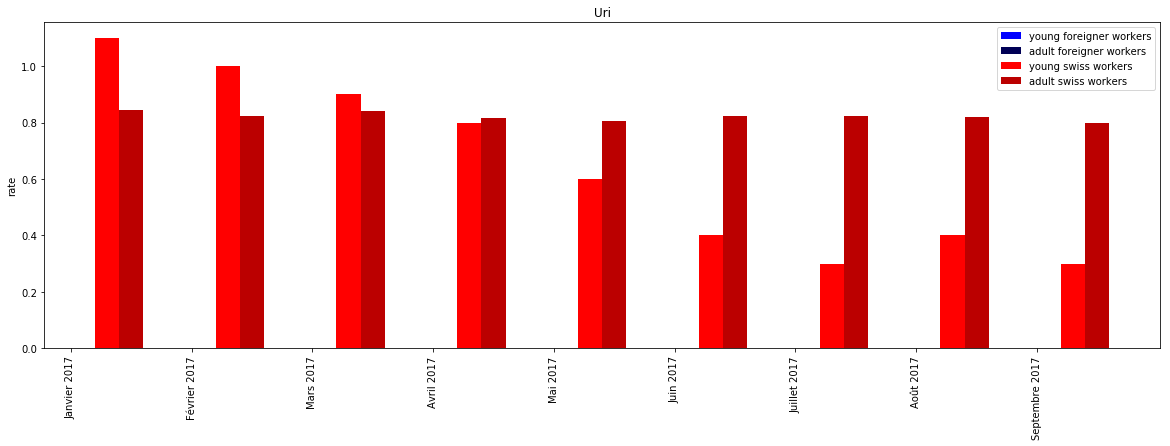

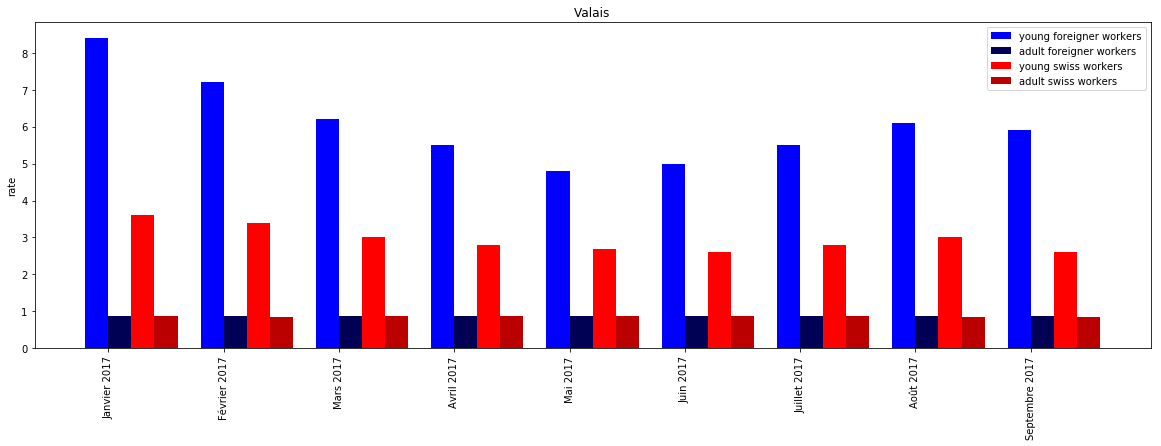

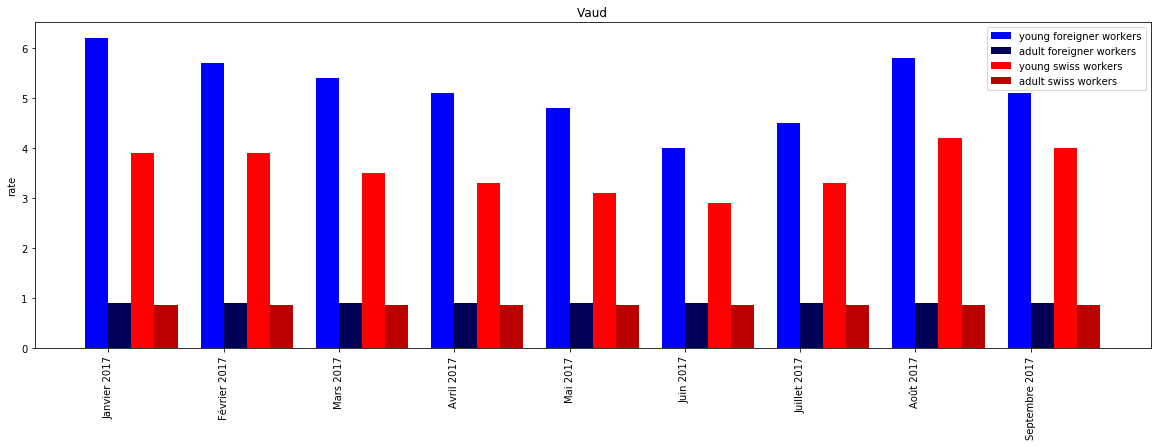

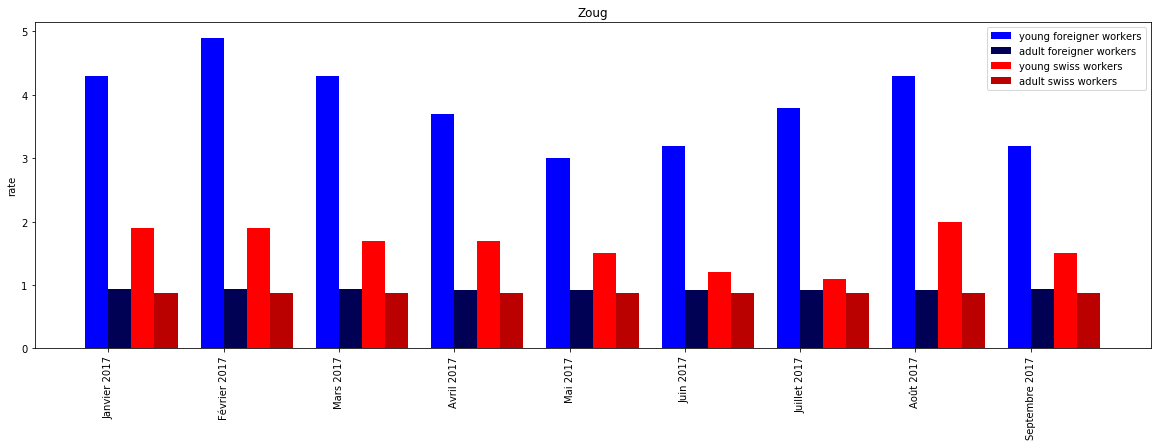

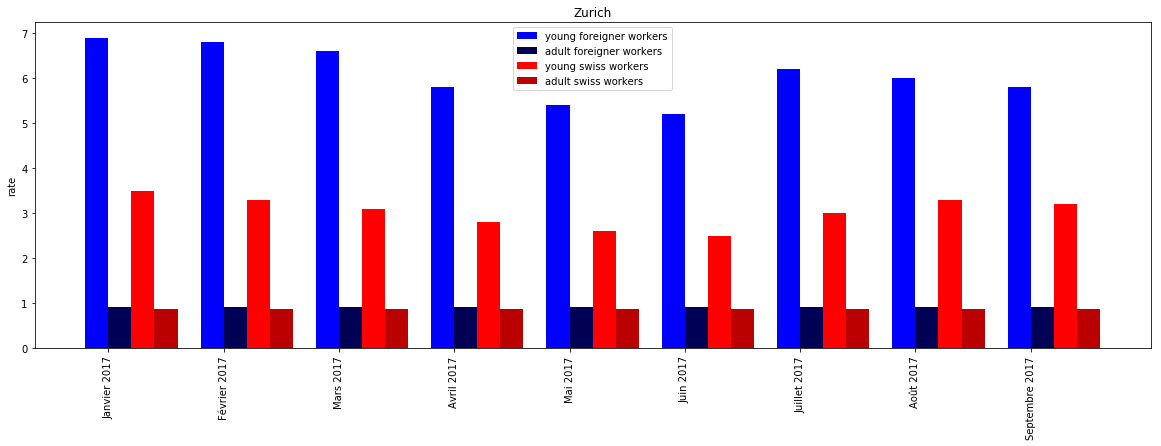

In [15]:
for title,table in df_final.groupby(level=[0], axis=1):
    N = 9
    un_young_foreigner = []
    un_adult_foreigner = []
    un_young_swiss = []
    un_adult_swiss = []
    
    labels = []
    
    ind = np.arange(0,10*N,10)  # the x locations for the groups
    width = 2       # the width of the bars
    
    fig, ax = plt.subplots()
    
    for month,data in table.iterrows():
        un_young_foreigner.append(data[0])
        un_adult_foreigner.append(data[1])
        un_young_swiss.append(data[3])
        un_adult_swiss.append(data[4])
        labels.append(month)
        
    rects1 = ax.bar(ind, un_young_foreigner, width, color='#0000ff')
    rects2 = ax.bar(ind+width, un_adult_foreigner, width, color='#000055')
    rects3 = ax.bar(ind+2*width, un_young_swiss, width, color='#ff0000')
    rects4 = ax.bar(ind+3*width, un_adult_swiss, width, color='#bb0000')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('rate')
    ax.set_title(title)

    ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),
              ('young foreigner workers', 'adult foreigner workers', 'young swiss workers', 'adult swiss workers'))
    plt.xticks(ind + width / 2, labels, rotation='vertical')
    plt.show()

The second solution seems better in term of vizualizazion 